## 1. Libraries and File Paths

In [1]:
import pandas as pd
import os
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rioxarray as rxr
from dask.diagnostics import ProgressBar

In [2]:
# Setting file paths
base_dir = "/global/scratch/users/yougsanghvi"

# Paths for stagg aggregated files for a specific year
stagg_folder_path = os.path.join(base_dir, "aggregated_results_gdnat_usa")
stagg_filename = "gdnat_usa_agg_1979.csv"
stagg_data_path = os.path.join(stagg_folder_path, stagg_filename)

# Paths for stagg aggregated files for all years
stagg_filename_allyrs = "gdnat_usa_agg_all_years.csv"
stagg_data_path_allyrs = os.path.join(stagg_folder_path, stagg_filename_allyrs)

# Paths for raw Gdnat data
raw_foldername = "gdnat_tiff_files_by_yr"
raw_filename = "gdnat_1979.tif"
raw_filepath = os.path.join(base_dir, raw_foldername, raw_filename)

# Define paths for usa county shapefile
usa_county_dir = os.path.join(base_dir, "shapefiles")
usa_county_filename = "tl_2016_us_county_mortality.shp"
usa_county_path = os.path.join(usa_county_dir, usa_county_filename)

# Paths for raw gdnat data
data_dir_cullen = os.path.join(
    "/global",
    "scratch",
    "users",
    "cmolitor",
)

data_dir_gdnat = os.path.join(data_dir_cullen, "global_suicide")
gdnat_1_path = os.path.join(
    data_dir_gdnat,
    "climate_data",
    "gdnat_ACCESS-CM2_tas_1979-1999_v2025-02-11.zarr",
)

gdnat_2_path = os.path.join(
    data_dir_gdnat,
    "climate_data",
    "gdnat_ACCESS-CM2_tas_2000-2020_v2025-02-11.zarr",
)

# path to Maren's era5 degree days file

era5_dd_folderpath = os.path.join("data", "climatedata", "USA")
era5_dd_filename = "temp_degreedays_1986_1999_USA_ERA5_pop_weights.csv"
era5_dd_filepath = os.path.join(base_dir, era5_dd_folderpath, era5_dd_filename)

## 2. Loading in Files

In [3]:
# Loading in county shapefile
usa_counties = gpd.read_file(usa_county_path)

In [4]:
# load file for all years combined
stagg_usa_data_allyrs = pd.read_csv(stagg_data_path_allyrs)

# Convert 'order_1' from monthly sum to approximate daily average
stagg_usa_data_allyrs["order_1_daily_avg"] = stagg_usa_data_allyrs["order_1"] / 30

# Summary statistics of the daily average
stagg_usa_data_allyrs

/tmp/ipykernel_592373/1736783273.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  stagg_usa_data_allyrs = pd.read_csv(stagg_data_path_allyrs)


,year,month,poly_id,order_1,order_2,order_3,order_4,order_1_daily_avg
0,1979,NaN,2016,NaN,NaN,NaN,NaN,NaN
1,1979,1.0,2016,NaN,NaN,NaN,NaN,NaN
2,1979,2.0,2016,NaN,NaN,NaN,NaN,NaN
3,1979,3.0,2016,NaN,NaN,NaN,NaN,NaN
4,1979,4.0,2016,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2612867,2004,8.0,69110,NaN,NaN,NaN,NaN,NaN
2612868,2004,9.0,69110,NaN,NaN,NaN,NaN,NaN
2612869,2004,10.0,69110,NaN,NaN,NaN,NaN,NaN
2612870,2004,11.0,69110,NaN,NaN,NaN,NaN,NaN


In [5]:
# load file for specific year speficied in path before
stagg_usa_data = pd.read_csv(stagg_data_path)

# Convert 'order_1' from monthly sum to approximate daily average
stagg_usa_data['order_1_daily_avg'] = stagg_usa_data['order_1'] / 30

# summary statistics of the daily average
print(stagg_usa_data["order_1_daily_avg"].describe())

stagg_usa_data

count    37572.000000
mean        12.677789
std         10.831252
min        -28.944177
25%          5.504370
50%         14.391188
75%         21.648227
max         35.602281
Name: order_1_daily_avg, dtype: float64


,year,month,poly_id,order_1,order_2,order_3,order_4,order_1_daily_avg
0,1979,NaN,2016,NaN,NaN,NaN,NaN,NaN
1,1979,1.0,2016,NaN,NaN,NaN,NaN,NaN
2,1979,2.0,2016,NaN,NaN,NaN,NaN,NaN
3,1979,3.0,2016,NaN,NaN,NaN,NaN,NaN
4,1979,4.0,2016,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
38733,1979,8.0,69110,NaN,NaN,NaN,NaN,NaN
38734,1979,9.0,69110,NaN,NaN,NaN,NaN,NaN
38735,1979,10.0,69110,NaN,NaN,NaN,NaN,NaN
38736,1979,11.0,69110,NaN,NaN,NaN,NaN,NaN


In [6]:
# load raw file for specific year

rds = rxr.open_rasterio(raw_filepath, masked=True)

In [7]:
# Load raw file for all years
gdnat_1 = xr.open_dataset(gdnat_1_path, chunks={"time": 365})
gdnat_2 = xr.open_dataset(gdnat_1_path, chunks={"time": 365})

In [8]:
# Load era5 DD files
era5_dd_data = pd.read_csv(era5_dd_filepath)
era5_dd_data

,year,month,poly_id,threshold_ninf_to_8,threshold_8_to_9,threshold_9_to_10,threshold_10_to_29,threshold_29_to_30,threshold_30_to_31,threshold_31_to_inf
0,NaN,NaN,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1986.0,1.0,1001,1618.051194,242.216424,203.680910,657.184481,0.000000,0.000000,0.0
2,1986.0,2.0,1001,769.614039,378.245882,353.753141,2068.354357,0.000000,0.000000,0.0
3,1986.0,3.0,1001,505.622802,493.115692,465.917397,3357.922793,0.000000,0.000000,0.0
4,1986.0,4.0,1001,71.699507,548.791399,536.367182,4705.845201,3.883854,0.890395,0.0
...,...,...,...,...,...,...,...,...,...,...
583963,1999.0,8.0,78030,0.000000,324.793835,324.793835,5641.513143,0.000000,0.000000,0.0
583964,1999.0,9.0,78030,0.000000,314.316615,314.316615,5459.191383,0.000000,0.000000,0.0
583965,1999.0,10.0,78030,0.000000,324.793835,324.793835,5508.748094,0.000000,0.000000,0.0
583966,1999.0,11.0,78030,0.000000,314.316615,314.316615,5080.848206,0.000000,0.000000,0.0


In [10]:
usa_counties

,ID_1,ID_2,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,ID_0,geometry
0,01,001,00161526,01001,Autauga,Autauga County,06,H1,G4020,None,33860,None,A,1539609015,25749942,+32.5322367,-086.6464395,244,"POLYGON ((-86.9031 32.54063, -86.90313 32.5410..."
1,01,003,00161527,01003,Baldwin,Baldwin County,06,H1,G4020,380,19300,None,A,4117584019,1133130502,+30.6592183,-087.7460666,244,"POLYGON ((-87.99068 30.55549, -87.99051 30.560..."
2,01,005,00161528,01005,Barbour,Barbour County,06,H1,G4020,None,21640,None,A,2291818680,50864677,+31.8702531,-085.4051035,244,"POLYGON ((-85.42982 32.04598, -85.42985 32.046..."
3,01,007,00161529,01007,Bibb,Bibb County,06,H1,G4020,142,13820,None,A,1612481559,9287974,+33.0158929,-087.1271475,244,"POLYGON ((-87.31226 33.08622, -87.31218 33.087..."
4,01,009,00161530,01009,Blount,Blount County,06,H1,G4020,142,13820,None,A,1670041875,15077458,+33.9773575,-086.5664400,244,"POLYGON ((-86.74919 33.9976, -86.74902 33.9975..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3223,72,151,01804556,72151,Yabucoa,Yabucoa Municipio,13,H1,G4020,490,41980,None,A,143005178,72592521,+18.0598584,-065.8598713,244,"POLYGON ((-65.94291 18.08924, -65.94273 18.089..."
3224,72,153,01804557,72153,Yauco,Yauco Municipio,13,H1,G4020,434,38660,None,A,175371915,1625260,+18.0856688,-066.8579009,244,"POLYGON ((-66.91602 18.09602, -66.91601 18.096..."
3225,78,010,02378248,78010,St. Croix,St. Croix Island,10,H4,G4020,None,None,None,N,215914994,645644841,+17.7352317,-064.7466437,244,"POLYGON ((-64.95318 17.66102, -64.95503 17.666..."
3226,78,020,02378249,78020,St. John,St. John Island,10,H4,G4020,None,None,None,N,50996518,186671948,+18.3304347,-064.7352610,244,"POLYGON ((-64.84372 18.35599, -64.84372 18.356..."


## 3. Verifying file correctness

In [10]:
null_check = era5_dd_data.isnull().values.any()
era5_nas = era5_dd_data[era5_dd_data.isnull().any(axis=1)]
null_counts = era5_dd_data.isnull().sum()

era5_nas_poly_ids = era5_dd_data[era5_dd_data.isnull().any(axis=1)]['poly_id'].unique().tolist()
era5_nas_poly_ids

[1001,
 1003,
 1005,
 1007,
 1009,
 1011,
 1013,
 1015,
 1017,
 1021,
 1023,
 1025,
 1027,
 1029,
 1031,
 1033,
 1035,
 1037,
 1039,
 1043,
 1047,
 1049,
 1051,
 1055,
 1057,
 1059,
 1061,
 1063,
 1067,
 1069,
 1071,
 1073,
 1075,
 1077,
 1079,
 1081,
 1083,
 1085,
 1089,
 1093,
 1095,
 1097,
 1101,
 1103,
 1105,
 1107,
 1109,
 1111,
 1113,
 1115,
 1117,
 1119,
 1121,
 1123,
 1125,
 1127,
 1129,
 1131,
 1133,
 2013,
 2016,
 2020,
 2050,
 2060,
 2070,
 2090,
 2100,
 2110,
 2122,
 2130,
 2150,
 2158,
 2164,
 2170,
 2180,
 2185,
 2188,
 2201,
 2220,
 2231,
 2240,
 2261,
 2280,
 2290,
 4001,
 4003,
 4005,
 4007,
 4009,
 4011,
 4013,
 4015,
 4017,
 4021,
 4023,
 4027,
 5001,
 5003,
 5005,
 5007,
 5009,
 5011,
 5013,
 5015,
 5017,
 5019,
 5021,
 5023,
 5025,
 5027,
 5029,
 5031,
 5033,
 5035,
 5037,
 5039,
 5041,
 5045,
 5049,
 5051,
 5053,
 5057,
 5059,
 5061,
 5063,
 5065,
 5067,
 5069,
 5071,
 5073,
 5077,
 5079,
 5081,
 5083,
 5087,
 5089,
 5091,
 5095,
 5097,
 5099,
 5101,
 5103,
 5105,

In [11]:
# Check for NA values in the entire DataFrame and sum them up per column
print("Number of NA values per column:")
print(stagg_usa_data.isnull().sum())

# Check for NA values in the entire DataFrame and get a boolean DataFrame
bool_na = stagg_usa_data.isnull()

# Check if there are any NA values in the entire DataFrame (returns a single boolean)
print("\nAre there any NA values in the DataFrame?")
print(stagg_usa_data.isnull().any().any())

# Get the total count of NA values in the entire DataFrame
print("\nTotal number of NA values in the DataFrame:")
print(stagg_usa_data.isnull().sum().sum())

nas_only_df = stagg_usa_data[stagg_usa_data.isnull().any(axis=1)]

# Display unique values of 'poly_id' in the filtered DataFrame
if 'poly_id' in nas_only_df.columns:
    unique_poly_ids = nas_only_df['poly_id'].unique()
    print("Unique values of 'poly_id' in the filtered DataFrame (nas_only.csv):")
    print(unique_poly_ids)
else:
    print("The 'poly_id' column does not exist in the filtered DataFrame.")

Number of NA values per column:
year                    0
month                   2
poly_id                 0
order_1              1166
order_2              1166
order_3              1166
order_4              1166
order_1_daily_avg    1166
dtype: int64

Are there any NA values in the DataFrame?
True

Total number of NA values in the DataFrame:
5832
Unique values of 'poly_id' in the filtered DataFrame (nas_only.csv):
[ 2016 15003  2050  2180 60040 60020 60030  2185  2013  2158  2188  2070
 15007  2164  2150 15001  2122  2261  2231  2220  2201  2130 53031  6015
  6075  6083  6111  6037 48321 55003 27031 26053 22075 26131 26083 26061
 17031 17097 55059 55101 55117 55079 55089 55071 26103 55061 55029 26021
 26121 26127 26041 26159 26005 26139 26105 26101 26003 26019 26089 26153
 26095 12045 26141 26069 26001 26007 26063 12075 12087 39043 26151 12015
 39093 12089 13039 39035 13127 13191 13179 39085 39007 37141 36055 36117
 37031 37095 36011 36075 36045 44005 72097 78010 66010 69085 69100 69

In [12]:
polys_tocheck = era5_dd_data[era5_dd_data['poly_id'].isin(unique_poly_ids)]

In [13]:
polys_tocheck
print(polys_tocheck['threshold_9_to_10'].isna().sum() / len(polys_tocheck) * 100)

100.0


## 4. Plotting

In [19]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray # Required for .rio accessor, ensures CRS handling
from dask.diagnostics import ProgressBar # For progress bar with xarray operations

def plot_climate_data(
    data,
    data_type, # 'county' or 'grid'
    usa_counties, # GeoDataFrame of US county boundaries
    column_name, # Name of the column (county) or variable (grid) containing the data values
    start_year=None, # Start year for temporal aggregation (inclusive).
    end_year=None,   # End year for temporal aggregation (inclusive).
    title=None, # Whole title input
    value_min=None, # Minimum value for the color scale (None means auto-determined by Matplotlib)
    value_max=None, # Maximum value for the color scale (None means auto-determined by Matplotlib)
    color_map="coolwarm", # Colormap for plotting
    lon_bounds=(-130, -65), # Longitude bounds for the plot extent
    lat_bounds=(23, 50)     # Latitude bounds for the plot extent
):
    """
    Generates a geospatial plot of climate data, supporting both county-level
    and grid-level input formats. The function performs temporal aggregation
    (annual or multi-year average) based on specified year ranges and overlays
    county boundaries.

    Args:
        data (pd.DataFrame or xr.DataArray):
            Input climate data.
            - If `data_type` is 'county': A pandas DataFrame containing monthly data
              with 'poly_id', 'year', 'month', and `column_name`.
            - If `data_type` is 'grid': An xarray DataArray containing monthly data
              with 'x'/'lon', 'y'/'lat' coordinates, and 'time'/'band' dimensions.
        data_type (str):
            Specifies the format of the input `data`: 'county' or 'grid'.
        usa_counties (gpd.GeoDataFrame):
            GeoDataFrame containing US county boundaries. Must include a 'GEOID'
            column, which will be cast to integer type for merging.
        column_name (str):
            The name of the column in the county DataFrame (e.g., 'order_1_daily_avg')
            or the variable name within the xarray DataArray (e.g., 'tas') that holds
            the climate values for plotting.
        start_year (int, optional):
            The beginning year for temporal aggregation (inclusive). If provided
            and `end_year` is None, `end_year` defaults to `start_year` (single-year average).
            If both `start_year` and `end_year` are None, aggregation occurs over
            all available years in the dataset. Defaults to None.
        end_year (int, optional):
            The ending year for temporal aggregation (inclusive). If provided
            without `start_year`, it is ignored, and aggregation occurs over
            all available years. Defaults to None.
        title (str, optional):
            The complete title string for the plot. If None, a default title is
            generated based on `data_type`, `column_name`, and the aggregated years.
            Defaults to None.
        value_min (float, optional):
            Minimum value for the color scale. If None, Matplotlib automatically
            determines the minimum based on the data's spread. Defaults to None.
        value_max (float, optional):
            Maximum value for the color scale. If None, Matplotlib automatically
            determines the maximum based on the data's spread. Defaults to None.
        color_map (str, optional):
            Matplotlib colormap to apply to the plot. Defaults to "coolwarm".
        lon_bounds (tuple, optional):
            A tuple (min_longitude, max_longitude) defining the horizontal
            extent of the plot. Defaults to (-130, -65) for mainland USA.
        lat_bounds (tuple, optional):
            A tuple (min_latitude, max_latitude) defining the vertical
            extent of the plot. Defaults to (23, 50) for mainland USA.

    Returns:
        None: Displays the generated plot.
    """

    processed_data = None
    plot_title_years_str = "" # String representation of the years for the plot title

    # Determine the effective start and end years for aggregation, and format title string
    if start_year is not None:
        if end_year is None:
            end_year = start_year # Single-year aggregation if only start_year is provided
        plot_title_years_str = f"{start_year}" if start_year == end_year else f"{start_year}-{end_year}"
    else:
        # If no specific years are provided, average over the entire dataset period
        plot_title_years_str = "All Years"


    # Ensure 'GEOID' column in the county GeoDataFrame is of integer type
    if 'GEOID' in usa_counties.columns:
        usa_counties["GEOID"] = usa_counties["GEOID"].astype(int)

    if data_type == 'county':
        # --- County Data Processing ---
        # Calculate the annual average temperature per polygon ('poly_id') and year
        # from the raw monthly data.
        annual_avg_per_county_year = (
            data.groupby(["poly_id", "year"])[column_name]
            .mean()
            .reset_index()
        )

        filtered_annual_data = annual_avg_per_county_year.copy()

        # Apply temporal filtering if start_year is specified
        if start_year is not None:
            filtered_annual_data = filtered_annual_data[
                filtered_annual_data["year"].between(start_year, end_year)
            ]

        # Compute the final average over the filtered annual data per polygon.
        # This yields either a single year's annual average or an average over the
        # specified multi-year range.
        processed_data_avg = filtered_annual_data.groupby("poly_id")[column_name].mean().reset_index()

        # Merge the aggregated data with the US county GeoDataFrame using GEOID.
        processed_data = usa_counties.merge(
            processed_data_avg, how="left", left_on="GEOID", right_on="poly_id"
        )
        # Set the plot title. If a custom title is not provided, generate a default.
        if title is None:
            plot_title = f"Average Temperature ({column_name}) - {plot_title_years_str} (Post-Aggregation)"
        else:
            plot_title = title

    elif data_type == 'grid':
        # --- Grid Data Processing ---
        grid_data_var = None

        # Determine if 'data' is a Dataset (collection of variables) or a DataArray (the variable itself)
        if isinstance(data, xr.Dataset):
            # If 'data' is a Dataset, extract the specific DataArray by 'column_name'
            if column_name not in data.data_vars:
                raise ValueError(f"'{column_name}' not found in the xarray.Dataset variables.")
            grid_data_var = data[column_name]
        elif isinstance(data, xr.DataArray):
            # If 'data' is already a DataArray, it is the variable to plot.
            # 'column_name' is then used as a label for units conversion and title.
            grid_data_var = data
            # Optionally, ensure the DataArray has a name for consistency if 'column_name' is intended as its name
            if grid_data_var.name is None:
                 grid_data_var.name = column_name # Assign column_name as the DataArray's name if unset
        else:
            raise TypeError("Expected xarray.Dataset or xarray.DataArray for grid data.")


        # Shift longitudes from 0-360 to -180-180 if needed.
        # This handles common global grid conventions. Sort by longitude after adjustment.
        if 'x' in grid_data_var.coords and grid_data_var.x.max() > 180:
            grid_data_var = grid_data_var.assign_coords({"x": ((grid_data_var.x + 180) % 360) - 180}).sortby("x")
        elif 'lon' in grid_data_var.coords and grid_data_var.lon.max() > 180:
            grid_data_var = grid_data_var.assign_coords({"lon": ((grid_data_var.lon + 180) % 360) - 180}).sortby("lon")

        averaged_grid = None

        # Perform temporal aggregation for grid data.
        # Prioritize 'time' dimension for explicit date-based filtering.
        if 'time' in grid_data_var.dims:
            if start_year is not None:
                # Select data within the specified year range and compute mean over time.
                start_date_str = f"{start_year}-01-01"
                end_date_str = f"{end_year}-12-31" # Inclusive end of year
                grid_time_filtered = grid_data_var.sel(time=slice(start_date_str, end_date_str))
                averaged_grid = grid_time_filtered.mean(dim="time", skipna=True)
            else:
                # If no specific years are provided, average over the entire 'time' dimension.
                averaged_grid = grid_data_var.mean(dim="time", skipna=True)
        elif 'band' in grid_data_var.dims:
            # If 'band' is the primary time-like dimension, average across bands.
            # Note: direct year filtering isn't applied here unless 'band' values
            # explicitly map to years, which is not assumed by default for 'band'.
            averaged_grid = grid_data_var.mean(dim="band", skipna=True)
            if start_year is not None: # Reflect provided years in title if available
                plot_title_years_str = f"{start_year}" if start_year == end_year else f"{start_year}-{end_year}"
            else:
                plot_title_years_str = "All Bands"
        else:
            # If no suitable time-like dimension is found, plot the original DataArray.
            print("Warning: Neither 'time' nor 'band' dimension found for averaging in grid data. Plotting original data.")
            averaged_grid = grid_data_var
            plot_title_years_str = "Original Data"

        # Convert temperature from Kelvin to Celsius if the column name suggests it's in Kelvin.
        if column_name == 'tas':
             processed_data = averaged_grid - 273.15
        else:
             processed_data = averaged_grid

        # Ensure the CRS is explicitly set for the xarray DataArray to allow proper
        # reprojection and alignment with county boundaries during plotting.
        if not processed_data.rio.crs:
            processed_data = processed_data.rio.write_crs("EPSG:4326", inplace=True) # Assume WGS84 for lat/lon data

        # Set the plot title. If a custom title is not provided, generate a default.
        if title is None:
            plot_title = f"Average Temperature ({column_name}) - {plot_title_years_str} Grid"
        else:
            plot_title = title

    else:
        # Handle invalid data_type input.
        print(f"Error: Invalid 'data_type': '{data_type}'. Please use 'county' or 'grid'.")
        return

    # --- Common Plotting Logic ---
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Construct a dictionary of plot arguments, conditionally including `vmin` and `vmax`.
    # Matplotlib will auto-scale if these are not provided.
    plot_kwargs = {
        'ax': ax,
        'cmap': color_map,
        # The 'legend' argument is only valid for certain plot types (e.g., GeoPandas plots with 'column').
        # xarray's .plot() handles colorbars automatically, and passing 'legend' can cause errors
        # with its underlying matplotlib QuadMesh object.
    }

    if value_min is not None:
        plot_kwargs['vmin'] = value_min
    if value_max is not None:
        plot_kwargs['vmax'] = value_max

    if data_type == 'county':
        # For county plots, the 'legend' argument controls the colorbar.
        plot_kwargs['legend'] = True
        # Plot county boundaries as a base layer.
        usa_counties.boundary.plot(ax=ax, color="gray", linewidth=0.2)
        # Plot the merged county data.
        processed_data.plot(
            column=column_name,
            **plot_kwargs
        )
    elif data_type == 'grid':
        # Use ProgressBar context for visualizing computation progress of large datasets.
        with ProgressBar():
            # Plot the grid data.
            processed_data.plot(
                **plot_kwargs # legend is not passed here
            )
        # Overlay county boundaries, ensuring they are reprojected to match the grid's CRS.
        usa_counties.to_crs(processed_data.rio.crs).boundary.plot(
            ax=ax, color="grey", linewidth=0.3
        )

    # Set the geographical extents of the plot to focus on mainland USA.
    ax.set_xlim(lon_bounds[0], lon_bounds[1])
    ax.set_ylim(lat_bounds[0], lat_bounds[1])

    # Apply the determined plot title and remove axis labels/ticks for a cleaner map.
    ax.set_title(plot_title)
    ax.axis("off")
    plt.show()


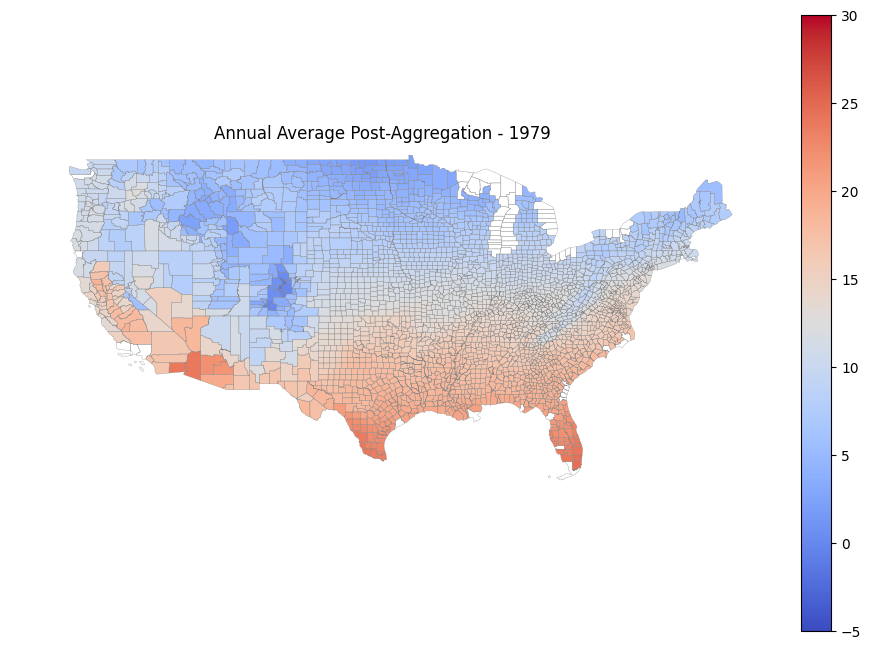

In [20]:
# Post aggregation for 1979

plot_climate_data(
    data=stagg_usa_data,  
    data_type='county',
    usa_counties=usa_counties,  
    column_name='order_1_daily_avg',
    start_year=1979,
    end_year=1979,
    title="Annual Average Post-Aggregation - 1979",
    value_min=-5,
    value_max=30,
    color_map="coolwarm",
    lon_bounds=(-130, -65),
    lat_bounds=(23, 50)
)

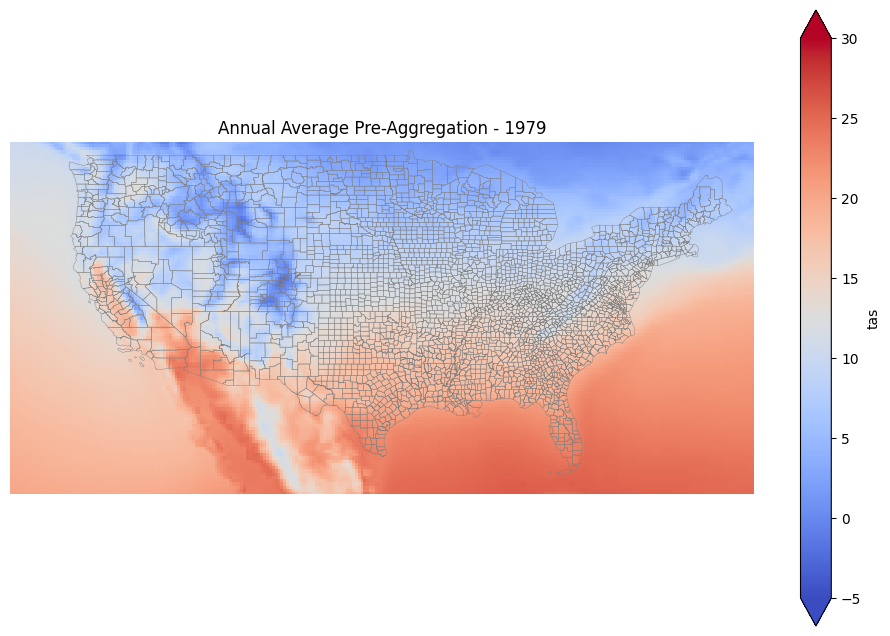

In [21]:
# Pre aggregation for 1979

plot_climate_data(
    data=rds,  
    data_type='grid',
    usa_counties=usa_counties,  
    column_name='tas',
    start_year=1979,
    end_year=1979,
    title="Annual Average Pre-Aggregation - 1979",
    value_min=-5,
    value_max=30,
    color_map="coolwarm",
    lon_bounds=(-130, -65),
    lat_bounds=(23, 50)
)

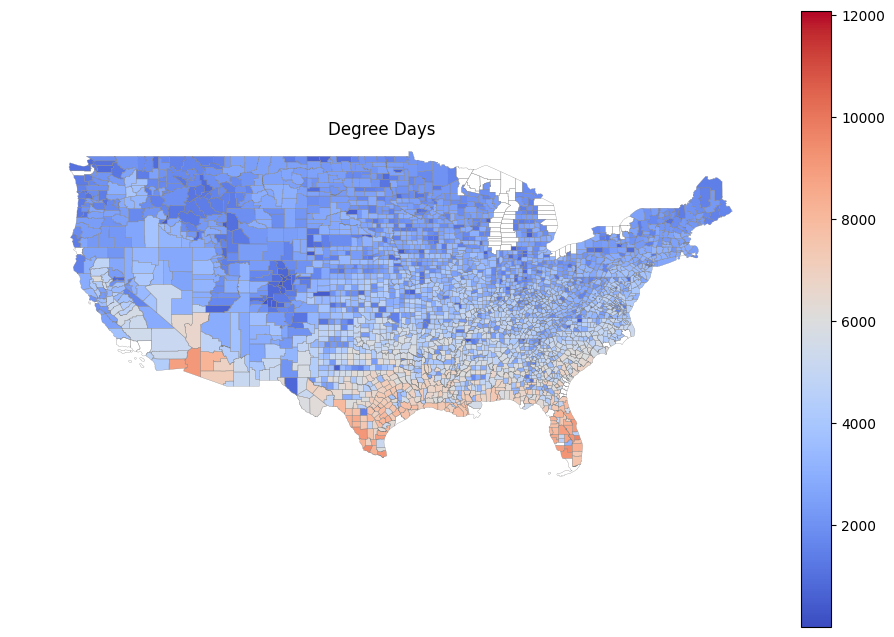

In [74]:
plot_climate_data(
    data=era5_dd_data,  # Your original monthly county data DataFrame
    data_type='county',
    usa_counties=usa_counties,  # Your GeoDataFrame of US county boundaries
    column_name='threshold_10_to_29',
    title="Degree Days",
    color_map="coolwarm",
    lon_bounds=(-130, -65),
    lat_bounds=(23, 50)
)

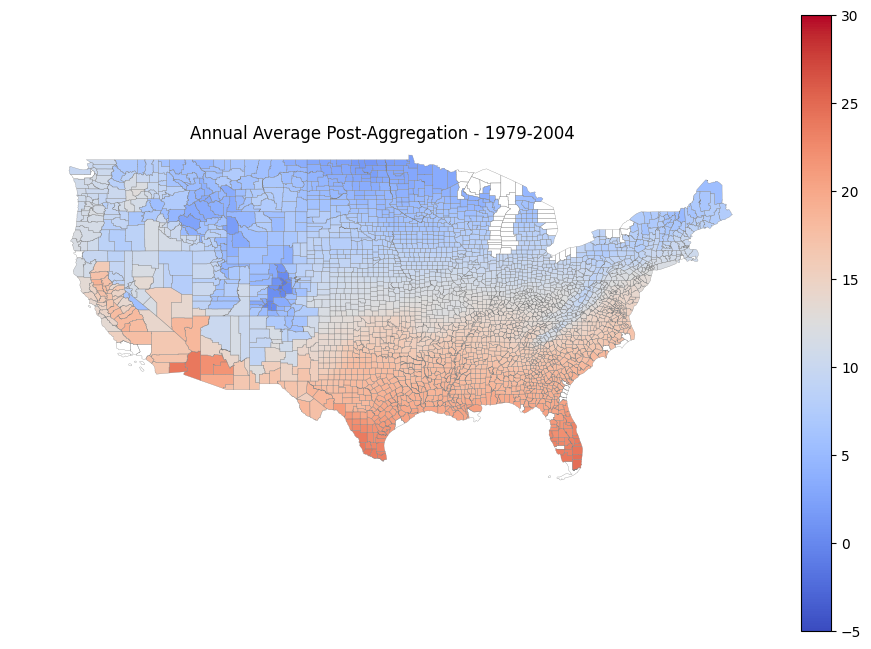

In [23]:
# Post aggregation for all years

plot_climate_data(
    data=stagg_usa_data,  
    data_type='county',
    usa_counties=usa_counties,  
    column_name='order_1_daily_avg',
    title="Annual Average Post-Aggregation - 1979-2004",
    value_min=-5,
    value_max=30,
    color_map="coolwarm",
    lon_bounds=(-130, -65),
    lat_bounds=(23, 50)
)

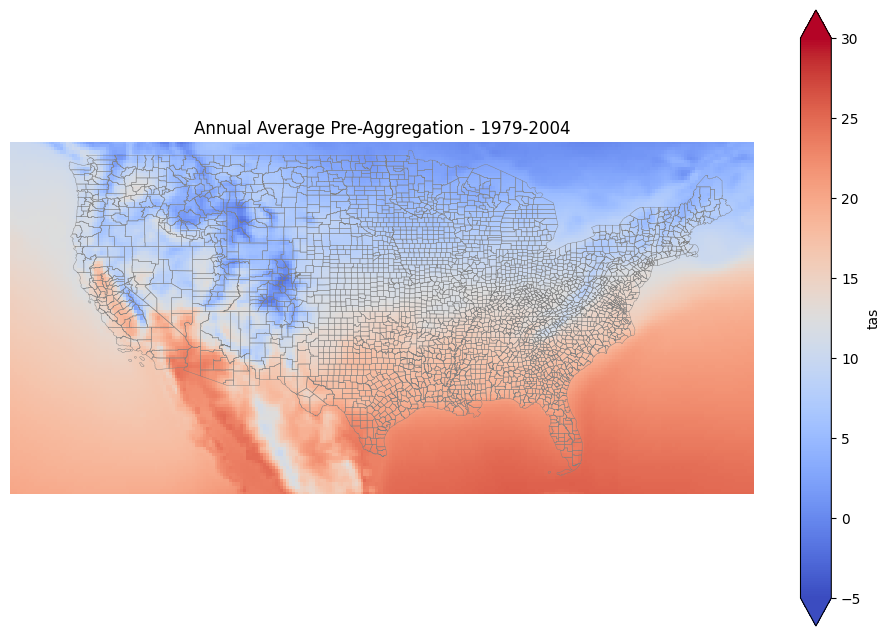

In [24]:
# Pre aggregation for all years

plot_climate_data(
    data=rds,  
    data_type='grid',
    usa_counties=usa_counties,  
    column_name='tas',
    title="Annual Average Pre-Aggregation - 1979-2004",
    value_min=-5,
    value_max=30,
    color_map="coolwarm",
    lon_bounds=(-130, -65),
    lat_bounds=(23, 50)
)

36061
       year  month  poly_id     order_1       order_2        order_3  \
36782  1979    1.0    36061    3.628400    789.822768    1760.831290   
36783  1979    2.0    36061 -165.150547   2176.720392  -26175.414792   
36784  1979    3.0    36061  203.750206   1743.295705   16496.701832   
36785  1979    4.0    36061  315.486001   3758.355355   48966.582911   
36786  1979    5.0    36061  536.270851   9413.676425  167773.190998   
36787  1979    6.0    36061  604.181749  12279.233656  251693.538351   
36788  1979    7.0    36061  736.242001  17694.016296  429549.893897   
36789  1979    8.0    36061  730.087704  17479.624147  424717.369110   
36790  1979    9.0    36061  603.421049  12512.716676  266827.936810   
36791  1979   10.0    36061  400.861069   5701.226460   87217.883198   
36792  1979   11.0    36061  305.481826   3417.508957   40950.433046   
36793  1979   12.0    36061  120.647498    911.986734    6640.109846   

            order_4  order_1_daily_avg  
36782  6.760109e

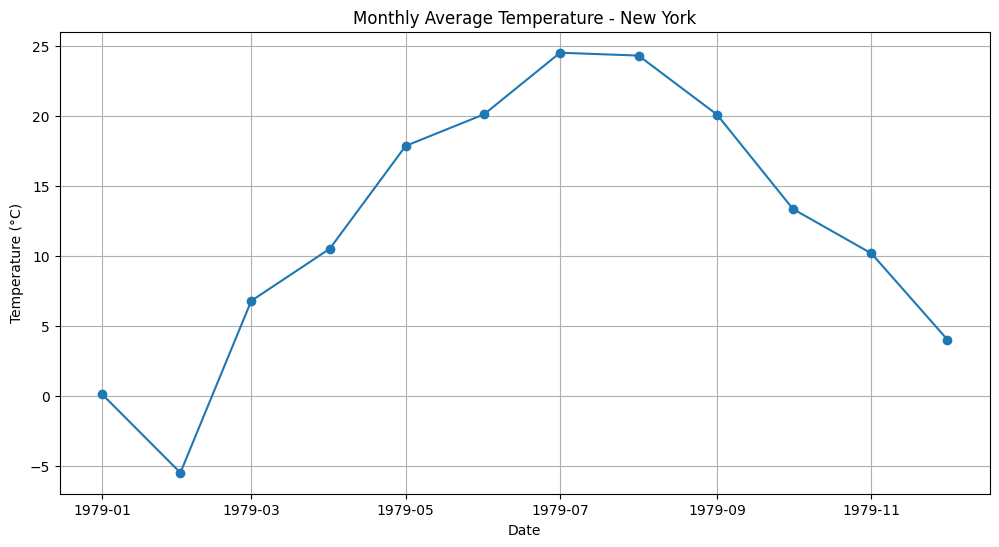

In [34]:
# Sample time series plot

county_name = "New York"
# Find specific county polygon ID directly by name
chosen_county = usa_counties.loc[
    usa_counties["NAME"] == county_name, "GEOID"
].values[0]

print(chosen_county)

# Filter stagg data for Alameda county
chosen_county__data = stagg_usa_data[stagg_usa_data["poly_id"] == chosen_county]

print(chosen_county__data)

# Sort by year and month
chosen_county__data = chosen_county__data.sort_values(["year", "month"])

# Create a datetime column for plotting
chosen_county__data["date"] = pd.to_datetime(
    dict(year=chosen_county__data["year"], month=chosen_county__data["month"], day=1)
)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    chosen_county__data["date"], chosen_county__data["order_1_daily_avg"], marker="o", linestyle="-"
)

ax.set_title(f"Monthly Average Temperature - {county_name}")
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (°C)")
ax.grid(True)

plt.show()
